In [221]:
import Dataset

import importlib
import csv

import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

import matplotlib.pyplot as plt
import pandas as pd

Dataset = importlib.reload(Dataset)

# Dataset

In [2]:
all_things = Dataset.get_recipe(Dataset.path)

In [3]:
name2idx, idx2name = Dataset.get_all_name(all_things)

In [4]:
# map the name list to an idx list
idx_list = list(map(lambda names:list(map(lambda name:name2idx[name], names)), all_things))

In [5]:
rdata=Dataset.recipe_data(idx_list)

In [6]:
rdata[3]

(tensor([84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84]),
 tensor([ 47, 174,  86, 334, 206, 316, 242, 343,  31, 217, 128,  17,  65, 187,
         195]),
 tensor([[159, 223],
         [ 88, 101],
         [206, 117],
         [149,  47],
         [260, 181],
         [334, 334],
         [324, 128],
         [334, 125],
         [211, 216],
         [324, 280],
         [317, 228],
         [334, 327],
         [ 75, 206],
         [304,  64],
         [334, 126]]))

# Model

In [7]:
import SkipGram as SG

SG = importlib.reload(SG)

In [189]:
model = SG.skipgram(vocab_size=len(name2idx), embedding_dim=25, dropout=True, p=0.5)

In [190]:
dataloader = data.DataLoader(rdata, batch_size=4, shuffle=True, collate_fn=SG.cf)

In [211]:
u, v, n = next(iter(dataloader))

In [215]:
model(u_pos=u.cuda(), v_pos=v.cuda(), v_neg=n.cuda(), batch_size=len(u))

tensor(1.3863, device='cuda:0', grad_fn=<DivBackward0>)

# Train

In [8]:
import wandb

class Reporter:
    def __init__(self, dt):
        self.dt = dt
        self.loss_count = {}
        self.k = 0.0
    
    def report(self):
        if self.k > 0:
            for k in self.loss_count.keys():
                self.loss_count[k] /= self.k
            wandb.log(self.loss_count)
    
    def step(self, loss_dict):
        self.k += 1
        for k, v in loss_dict.items():
            if not (k in self.loss_count):
                self.loss_count[k] = 0.0
            self.loss_count[k] += v
        if self.k >= self.dt:
            self.report()
            self.k = 0
            for k in self.loss_count.keys():
                self.loss_count[k] = 0.0

In [9]:
import os

def train(net, training_data, optimizer, epco, dt):
    wandb.init(config=args, project="Skip-gram Dropout (Recipe)")
    #wandb.config["more"] = f"rule {110}"

    reporter = Reporter(dt)
    net.train()
    scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
    
    for i in range(epco):
        t = 0
        for u,v,n in training_data:
            t += 1
            optimizer.zero_grad()
            if torch.cuda.is_available():
                u = u.cuda()
                v = v.cuda()
                n = n.cuda()
            
            loss = net(u_pos=u, v_pos=v, v_neg=n, batch_size=len(u))
            
            loss.backward()
            optimizer.step()
            reporter.step({'loss':loss.cpu().item(), 'epco':i+t/len(training_data)}) # report to wandb
        #scheduler.step()
    net.eval()
    net.cpu()
    torch.save(net, os.path.join(wandb.run.dir, 'model.pth'))
    return net

In [10]:
args = {'epco':1000, 'lr':0.2, 'dim':25, 'batch_size':128}
model = SG.skipgram(vocab_size=len(name2idx), embedding_dim=25, dropout=False, p=0.5)

if torch.cuda.is_available():
    model.cuda()
opt = optim.SGD(model.parameters(), lr=args['lr'], weight_decay=0)

training_data = data.DataLoader(rdata, batch_size=args['batch_size'], shuffle=True, collate_fn=SG.cf)
train(model, training_data, opt, args['epco'], 250)

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


KeyboardInterrupt: 

In [16]:
import json

with open('idx2name.json', 'w') as f:
    json.dump(idx2name, f)

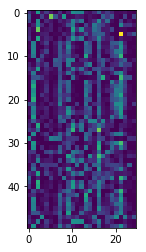

In [74]:
plt.imshow(normalize(model.u_embeddings.weight.data.cpu()[:50]))
plt.show()

In [256]:
idx2name[47]

'butter'

In [297]:
target = torch.zeros(25)
target[0] = 1

In [24]:
normalize = lambda x:((x**2).t() / torch.sum(x**2, dim=1)).t()
entropy = lambda x:torch.sum(-1 * x * torch.log(x), dim=1)

In [26]:
H = entropy(normalize(model.u_embeddings.weight.data))

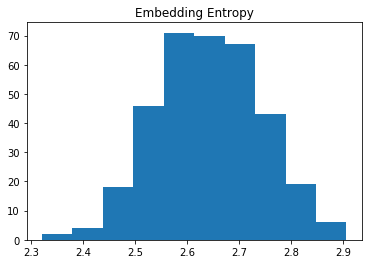

In [30]:
plt.hist(H.cpu())
plt.title('Embedding Entropy')
plt.show()

In [298]:
similarity = torch.cosine_similarity(target.unsqueeze(0), model.u_embeddings.weight.data)
most_similar = torch.argsort(similarity)[-5:]

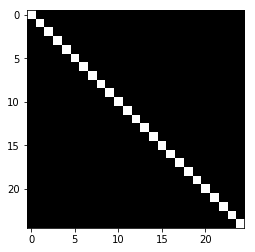

In [39]:
class_mat = torch.diag(torch.ones(25))
plt.imshow(class_mat, cmap='gray')
plt.show()

In [61]:
def ClassifyByCode(embeds):
    n, dim = embeds.shape
    embeds = embeds.cpu()
    class_mat = torch.diag(torch.ones(dim))
    classes = []
    for emb in embeds:
        simi = torch.cosine_similarity(class_mat, emb.unsqueeze(0))
        cla = torch.argmax(simi).item()
        classes.append(cla)
    return classes

In [63]:
classes=ClassifyByCode(model.u_embeddings.weight.data)

In [64]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

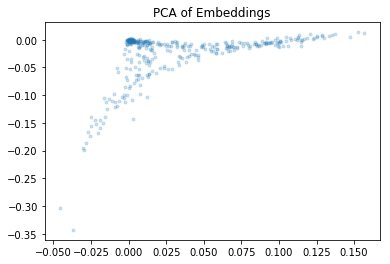

In [70]:
pca=PCA(n_components=2, random_state=0)
pca.fit(np.array(model.u_embeddings.weight.data.cpu().tolist()).T)
plt.plot(pca.components_[0], pca.components_[1], '.', alpha=0.2)
plt.title('PCA of Embeddings')
plt.show()

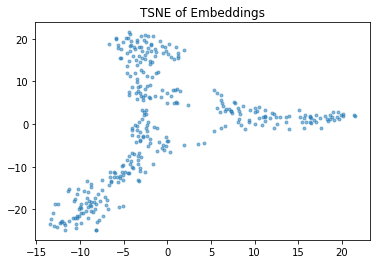

In [72]:
tsne=TSNE(n_components=2, random_state=0)
tsne.fit(np.array(model.u_embeddings.weight.data.cpu().tolist()))
plt.plot(tsne.embedding_.T[0], tsne.embedding_.T[1], '.', alpha=0.5)
plt.title('TSNE of Embeddings')
plt.show()

# Embedding

## With Dropout

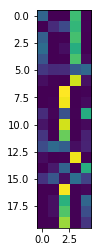

In [86]:
dropout5d = torch.load('./data/word2vec_dropout/dropout/dropout_d5.pth')
emb_dropout = dropout5d.u_embeddings.weight.data
plt.imshow(normalize(emb_dropout[:20]))
plt.show()

In [220]:
top_names = {}
for i in range(5):
    onehot = torch.argsort(torch.cosine_similarity(emb_dropout, torch.diag(-1*torch.ones(5))[i].unsqueeze(0)))[-10:]
    top10 = list(map(lambda x:idx2name[x.item()].replace('_', ' '), onehot))[::-1]
    top_names[i] = top10

pd.DataFrame(top_names)

,0,1,2,3,4
0,butter,egg,lingonberry,raspberry,durian
1,milk,mutton,bergamot,strawberry,black raspberry
2,corn flake,lilac flower oil,black currant,gelatin,violet
3,cream,cassava,lilac flower oil,rum,peppermint oil
4,yeast,popcorn,durian,cherry,rye flour
5,buttermilk,balm,champagne wine,blueberry,roasted hazelnut
6,cream cheese,pimenta,blackberry brandy,coconut,huckleberry
7,wheat,roasted almond,mate,fruit,cacao
8,milk fat,mate,gin,peach,peppermint
9,lard,black raspberry,black tea,citrus,sour cherry


Embedding with dropout results to a more sparse coding (in terms of entropy):

$$H = -\sum_i \hat x_i \ln \hat x_i,$$

where $\hat x_i = x^2_i / \sum_j x^2_i$

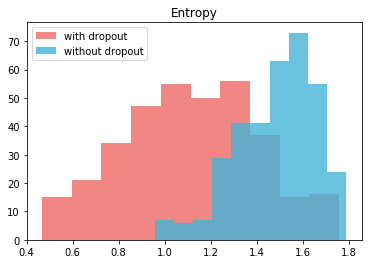

In [237]:
plt.hist(entropy(torch.abs(normalize2(emb_dropout))), alpha=0.8, label='with dropout', color='#EE6866')
plt.hist(entropy(torch.abs(normalize2(emb))), alpha=0.8, label='without dropout', color='#43B4D6')
plt.title('Entropy')
plt.legend()
plt.savefig('./entropy.pdf')
plt.show()

In [160]:
def ClassifyByCode(embeds):
    n, dim = embeds.shape
    embeds = embeds.cpu()
    class_mat = torch.diag(torch.ones(dim))
    classes = []
    for _emb in embeds:
        simi = torch.abs(torch.cosine_similarity(class_mat, _emb.unsqueeze(0)))
        cla = torch.argmax(simi).item()
        classes.append(cla)
    return classes

In [225]:
normalize2 = lambda x:((x).t() / torch.sqrt(torch.sum(x**2, dim=1))).t()

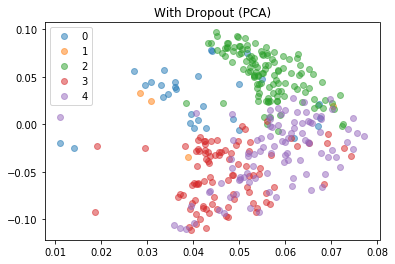

In [227]:
classes_dropout = np.array(ClassifyByCode(emb_dropout))
pca=PCA(n_components=2, random_state=0)
pca.fit(np.array(normalize2(emb_dropout).tolist()).T)

emb_by_class = []
for i in range(5):
    _emb = pca.components_.T[np.argwhere(classes_dropout == i)].reshape(-1,2)
    emb_by_class.append(_emb)

for embs,i in zip(emb_by_class, range(5)):
    plt.plot(embs.T[0], embs.T[1], 'o', alpha=0.5, label=str(i))

plt.legend()
plt.title('With Dropout (PCA)')
plt.savefig('./emb_dropout_PCA.pdf')
plt.show()

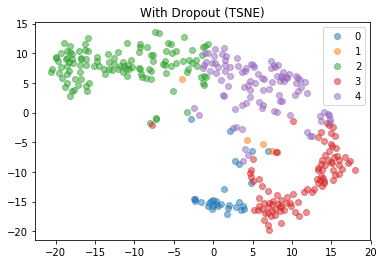

In [228]:
classes_dropout = np.array(ClassifyByCode(emb_dropout))
tsne=TSNE(n_components=2, random_state=0, perplexity=30)
tsne.fit(np.array(normalize2(emb_dropout)))

emb_by_class = []
for i in range(5):
    _emb = tsne.embedding_[np.argwhere(classes_dropout == i)].reshape(-1,2)
    emb_by_class.append(_emb)

for embs,i in zip(emb_by_class, range(5)):
    plt.plot(embs.T[0], embs.T[1], 'o', alpha=0.5, label=str(i))

plt.legend()
plt.title('With Dropout (TSNE)')
plt.savefig('./emb_dropout_TSNE.pdf')
plt.show()

## Without Dropout

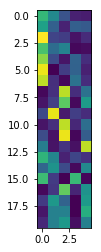

In [163]:
nodropout5d = torch.load('./data/word2vec_dropout/no_dropout/no_dropout_d5.pth')
emb = nodropout5d.u_embeddings.weight.data
plt.imshow(normalize(emb[:20]))
plt.show()

In [215]:
top_names = {}
for i in range(5):
    onehot = torch.argsort(torch.abs(torch.cosine_similarity(emb, torch.diag(torch.ones(5))[i].unsqueeze(0))))[-10:]
    top10 = list(map(lambda x:idx2name[x.item()].replace('_', ' '), onehot))[::-1]
    top_names[i] = top10

pd.DataFrame(top_names)

,0,1,2,3,4
0,cassava,cilantro,white bread,gin,shellfish
1,orange flower,roasted hazelnut,munster cheese,grape,ouzo
2,seed,avocado,bread,champagne wine,pimenta
3,cardamom,lettuce,chive,roasted peanut,leaf
4,salmon roe,sesame oil,wheat bread,papaya,durian
5,anise,celery oil,cottage cheese,guava,egg
6,lemon,soy sauce,rye bread,watermelon,brussels sprout
7,tangerine,cumin,jasmine tea,grapefruit,balm
8,plum,chickpea,chinese cabbage,tequila,jasmine
9,elderberry,radish,potato chip,wine,squid


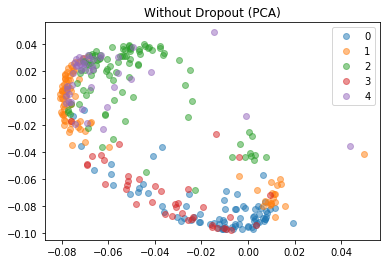

In [229]:
classes_dropout = np.array(ClassifyByCode(emb))
pca=PCA(n_components=2, random_state=0)
pca.fit(np.array(normalize2(emb).tolist()).T)

emb_by_class = []
for i in range(5):
    _emb = pca.components_.T[np.argwhere(classes_dropout == i)].reshape(-1,2)
    emb_by_class.append(_emb)

for embs,i in zip(emb_by_class, range(5)):
    plt.plot(embs.T[0], embs.T[1], 'o', alpha=0.5, label=str(i))

plt.legend()
plt.title('Without Dropout (PCA)')
plt.savefig('./emb_no_dropout_PCA.pdf')
plt.show()

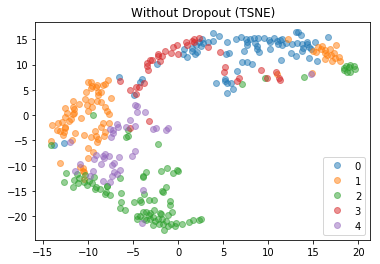

In [230]:
classes_dropout = np.array(ClassifyByCode(emb))
tsne=TSNE(n_components=2, random_state=0, perplexity=30)
tsne.fit(np.array(normalize2(emb).tolist()))

emb_by_class = []
for i in range(5):
    _emb = tsne.embedding_[np.argwhere(classes_dropout == i)].reshape(-1,2)
    emb_by_class.append(_emb)

for embs,i in zip(emb_by_class, range(5)):
    plt.plot(embs.T[0], embs.T[1], 'o', alpha=0.5, label=str(i))

plt.legend()
plt.title('Without Dropout (TSNE)')
plt.savefig('./emb_no_dropout_TSNE.pdf')
plt.show()

In [ ]:
classes_dropout = np.array(ClassifyByCode(emb))
tsne=TSNE(n_components=2, random_state=0, perplexity=30)
tsne.fit(np.array(normalize2(emb).tolist()))

emb_by_class = []
for i in range(5):
    _emb = tsne.embedding_[np.argwhere(classes_dropout == i)].reshape(-1,2)
    emb_by_class.append(_emb)

for embs,i in zip(emb_by_class, range(5)):
    plt.plot(embs.T[0], embs.T[1], 'o', alpha=0.5, label=str(i))

plt.legend()
plt.title('Without Dropout (TSNE)')
plt.savefig('./emb_no_dropout_TSNE.pdf')
plt.show()